In [176]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import ast
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [177]:
processed_path = '../Data/Processed/sub01_binned.csv'
eeg_data = pd.read_csv(processed_path)

eeg_task_path = '../Data/Processed/sub01_binned_task.csv'
eeg_task = pd.read_csv(eeg_task_path)

In [178]:
class EEGDataset(Dataset):
    def __init__(self, eeg_data, labels):
        self.eeg_data = eeg_data
        self.labels = labels

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        X = torch.tensor(self.eeg_data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return X, y

In [179]:
def preprocess_data(eeg_data, target_length=2047):
    # Drop the label columns to get only electrode data
    electrode_data = eeg_data.drop(columns=['label', 'label_type'])
    y = eeg_data['label_type']
    
    X = []
    for electrode in tqdm(electrode_data.columns, desc='Preprocessing'):
        electrode_series = electrode_data[electrode].apply(lambda x: ast.literal_eval(x)).tolist()
        
        # Standardize the length of each list to `target_length`
        standardized_series = []
        for series in electrode_series:
            if len(series) > target_length:
                # Trim the series
                series = series[:target_length]
            elif len(series) < target_length:
                # Pad the series with zeros
                series = series + [0] * (target_length - len(series))
            standardized_series.append(series)
        
        X.append(standardized_series)
    
    # Transpose to shape (samples, channels, time_points)
    X = torch.tensor(X).transpose(0, 1).detach().cpu().numpy()  # Convert to NumPy array

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    return X, y

In [180]:
class EEG_CNN(nn.Module):
    def __init__(self):
        super(EEG_CNN, self).__init__()
        
        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn1 = nn.InstanceNorm1d(128)
        
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.InstanceNorm1d(256)
        
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn3 = nn.InstanceNorm1d(512)
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)

        # Placeholder for dynamically initializing the fully connected layer
        self.fc1 = None
        self.fc2 = nn.Linear(128, 2)  # Binary classification

    def forward(self, x):
        # Convolutional layers with Batch Normalization, ReLU, and Pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, features]
        
        # Dynamically initialize the first fully connected layer
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.shape[1], 128).to(x.device)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [181]:
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")


In [182]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [183]:
def normalize_data(X):
    """
    Normalize the input data.
    X is expected to have the shape (n_samples, n_channels, n_timepoints).
    """
    scaler = StandardScaler()
    # Flatten to 2D shape (samples, features) for normalization
    X = X.reshape(X.shape[0], -1)
    X = scaler.fit_transform(X)
    # Reshape back to original 3D shape (samples, channels, timepoints)
    X = X.reshape(-1, 64, 2047)  # Adjust '64' and '2047' according to your data dimensions
    return X

In [184]:
def run_pipeline(eeg_data):
    # Preprocess the data
    X, y = preprocess_data(eeg_data)

    # Normalize the data
    X = normalize_data(X)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create PyTorch Datasets and DataLoaders
    train_dataset = EEGDataset(X_train, y_train)
    test_dataset = EEGDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize the model, criterion, and optimizer
    model = EEG_CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train and evaluate the model
    train_model(model, train_loader, criterion, optimizer, epochs=30)
    evaluate_model(model, test_loader)

Preprocessing: 100%|██████████| 64/64 [00:58<00:00,  1.10it/s]


Epoch 1/30, Loss: 0.7521402090787888
Epoch 2/30, Loss: 0.6906312331557274
Epoch 3/30, Loss: 0.6704694405198097
Epoch 4/30, Loss: 0.6556043028831482
Epoch 5/30, Loss: 0.6474374607205391
Epoch 6/30, Loss: 0.6383498087525368
Epoch 7/30, Loss: 0.6303055137395859
Epoch 8/30, Loss: 0.6183942183852196
Epoch 9/30, Loss: 0.6312491595745087
Epoch 10/30, Loss: 0.6194687113165855
Epoch 11/30, Loss: 0.6076289266347885
Epoch 12/30, Loss: 0.6090283766388893
Epoch 13/30, Loss: 0.5970935001969337
Epoch 14/30, Loss: 0.5973978862166405
Epoch 15/30, Loss: 0.5816421136260033
Epoch 16/30, Loss: 0.5917776711285114
Epoch 17/30, Loss: 0.5893997251987457
Epoch 18/30, Loss: 0.5828107818961143
Epoch 19/30, Loss: 0.5745280086994171
Epoch 20/30, Loss: 0.5641450583934784
Epoch 21/30, Loss: 0.5405247285962105
Epoch 22/30, Loss: 0.5512313209474087
Epoch 23/30, Loss: 0.555390365421772
Epoch 24/30, Loss: 0.5264910459518433
Epoch 25/30, Loss: 0.5383398272097111
Epoch 26/30, Loss: 0.521647784858942
Epoch 27/30, Loss: 0.51

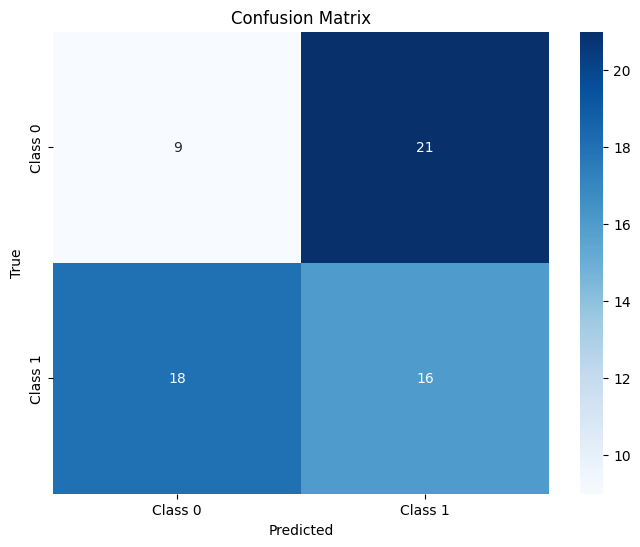

In [185]:
run_pipeline(eeg_task)